<a href="https://colab.research.google.com/github/romaz21/study/blob/main/Copy_of_hw_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Композиции алгоритмов
В этом домашнем задании вам предстоит обучить два вида композиций алгоритмов: бэггинг и бустинг.

## Постановка задачи
Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

## Метрика качества
В качестве целевой метрики мы будем использовать ROC-AUC. Об этой метрике мы говорили в модуле о метриках. Как вы помните, для измерения ROC-AUC требуются вероятности принадлежности к классам. Для решающих деревьев вероятность принадлежности к классу вычисляется как доля объектов из обучающей выборки в соответствующем листе. Для алгоритма, который принимает решение взвешенным голосованием, вероятность вычисляется как среднее взвешенное значение вероятностей по всем алгоритмам в композиции.

## Ход работы
* Первым делом вы произведете загрузку и обработку данных. В частности, вам необходимо будет закодировать категориальные признаки с помощью One-hot encoding.
* Сначала мы построим для нашей задачи обычный случайный лес и измерим его качество. Мы подберем оптимальный гиперпараметр "глубина дерева" для случайного леса.
* Далее мы обучим алгоритм градиентного бустинга с помощью библиотеки Catboost. Catboost --- это библиотека для градиентного бустинга, которая автоматически обрабатывает категориальные признаки. Поэтому для этого пункта вам нужно будет использовать не One-hot признаки, а изначальные категориальные признаки.

## Оценивание
В этом домашнем задании данные разделены на две части:
* [`data_train.csv`](https://drive.google.com/file/d/1qKakViWhNT1yTiM66V9hxADAVCYTL0PO/view?usp=share_link). Для этих данных вам известно значение целевой переменной. Эти данные вы будете использовать для обучения.
* [`data_scoring.csv`](https://drive.google.com/file/d/1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ/view?usp=share_link). На этих данных вы должны будете применить готовую модель, а затем сдать результаты в Stepik. Вам необходимо будет сдать результат работы двух моделей: случайного леса и градиентного бустинга.



## Часть 1. Загрузка и обработка данных
Загрузка данных будет состоять из следующих шагов:
* Загрузка из файла;
* Работа с пропущенными значениями;
* Выделение целевой переменной;
* Разбиение данных на вещественные и категориальные;
* One-hot кодирование категориальных данных;
* Разбиение данных на train и test.

Затем все эти шаги (кроме последнего) необходимо будет применить к `data_scoring`.

In [120]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [121]:
!gdown 1qKakViWhNT1yTiM66V9hxADAVCYTL0PO #эта команда скачивает файл data_train.csv и помещает его в корневую директорию Colab. Очень удобно!

Downloading...
From: https://drive.google.com/uc?id=1qKakViWhNT1yTiM66V9hxADAVCYTL0PO
To: /content/data_train.csv
100% 1.40M/1.40M [00:00<00:00, 133MB/s]


In [122]:
data = pd.read_csv('data_train.csv')

In [123]:
data.shape

(14734, 14)

In [124]:
data[:10]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


### Задание
Проведите с данными необходимые операции:

* Замените все знаки "?" на `np.nan`.
* Найдите все столбцы со значениями NaN. Напечатайте их названия.
* Выделите вектор ответов. Закодируйте правильные ответы 0 и 1:
    * '<=50K' -> 0;
    * '>50K' -> 1.
* Сохраните их в отдельную переменную `y` типа `np.array`.
* Удалите из data правильные ответы.

In [125]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14729,18,Private,395567,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,40,<=50K
14730,62,?,94931,Assoc-voc,11,Married-civ-spouse,?,Husband,White,Male,3411,0,40,<=50K
14731,34,Private,261023,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1651,38,<=50K
14732,26,Private,195327,HS-grad,9,Never-married,Sales,Own-child,White,Male,0,0,40,<=50K


In [126]:
data[data == '?'] = np.nan

In [127]:
y = data['>50K,<=50K']
z = lambda x: x=='>50K' * 1
#data = # ВАШ КОД
y = z(y).astype(np.int32, copy=False)

**Вопрос**. В каких колонках присутствуют пропущенные значения?

In [128]:
# Найдите колонки с пропущенными значениями
data.isna().any(axis=0)

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
>50K,<=50K        False
dtype: bool

Удалим ответы из data.

In [129]:
data = data.drop('>50K,<=50K', 1)

<ipython-input-129-39d7579a6e80>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('>50K,<=50K', 1)


**Вопрос**. Какие из признаков являются вещественными?

Выделите вещественные и категориальные признаки.

In [130]:
data.columns[list(data.dtypes == 'int64')]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [131]:
real_columns = data.columns[list(data.dtypes == 'int64')]

real_data = data[real_columns]
real_data[:10]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
5,18,446771,10,0,0,25
6,31,108464,12,0,0,40
7,18,423460,7,0,0,36
8,25,110138,9,0,0,40
9,53,167410,13,0,0,40


In [132]:
cat_columns = data.columns[list(data.dtypes == 'object')]

cat_data = data[cat_columns]
cat_data[:10]

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male
5,Private,Some-college,Never-married,Adm-clerical,Own-child,White,Male
6,Federal-gov,Assoc-acdm,Married-civ-spouse,Tech-support,Husband,White,Male
7,NaN,11th,Never-married,NaN,Own-child,White,Male
8,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male
9,Federal-gov,Bachelors,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male


### Задание
Выделите One-hot признаки из данных с помощю объекта `OneHotEncoder` из модуля `sklearn.preprocessing`.

In [133]:
from sklearn.preprocessing import OneHotEncoder

In [134]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_data = ohe.fit_transform(cat_data) #ВАШ КОД. Выделите one-hot признаки. Используйте метод fit_transform
one_hot_data = pd.DataFrame(one_hot_data, index=cat_data.index)
one_hot_data[:10]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Наконец, разобьем данные на train и test в соотношении 70:30.

In [135]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_real_data, test_real_data, \
train_cat_data, test_cat_data, train_one_hot_data, test_one_hot_data, \
y_train, y_test = train_test_split(data, real_data,
                                   cat_data, one_hot_data,
                                   y, train_size=0.7)

### Задание
Проделайте все то же самые операции для scoring_data.
* Загрузите данные из файла data_scoring.csv;
* Замените "?" на `np.nan`;
* Выделите числовые и категориальные данные;
* Закодируйте категориальные данные с помощью уже созданного `ohe`. Новый объект класса `OneHotEncoding` создавать не нужно. Используйте метод `ohe.transform`.

In [305]:
!gdown 1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ

Downloading...
From: https://drive.google.com/uc?id=1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ
To: /content/data_scoring.csv
100% 139k/139k [00:00<00:00, 88.5MB/s]


In [306]:
scoring_data = pd.read_csv('data_scoring.csv')
scoring_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,17,?,256173,10th,6,Never-married,?,Own-child,White,Female,0,0,15
1,31,Private,265706,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,0,0,40
2,61,Self-emp-not-inc,244087,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,52
3,60,Local-gov,232618,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40
4,56,Private,34626,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,1980,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40
1542,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45
1543,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40
1544,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40


In [307]:
scoring_data = pd.read_csv('data_scoring.csv')

scoring_data[scoring_data == '?'] = np.nan #Обработайте пропущенные значения
scoring_real_data = scoring_data[scoring_data.columns[list(scoring_data.dtypes == 'int64')]] #ВАШ КОД. Выделите числовые колонки
scoring_cat_data = scoring_data[scoring_data.columns[list(scoring_data.dtypes == 'object')]] #ВАШ КОД. Выделите категориальные колонки
scoring_one_hot_data = pd.DataFrame(ohe.transform(scoring_cat_data)) #ВАШ КОД. Выделите ohe-признаки. Не забудьте создать pd.DataFrame

In [308]:
scoring_one_hot_data

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1542,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1543,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1544,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## Часть 2. Обучение случайного леса
Мы будем использовать модель `RandomForestClassifier` из `sklearn.ensemble`. Вам предстоит подобрать для случайного леса оптимальный параметр глубины. Количество деревьев в этом задании мы будем использовать постоянным и равным 100.

Выбор параметра мы будем производить с помощью кросс-валидации на 5 фолдов, используя метод `cross_val_score` из `sklearn.model_selection`. Затем мы обучим окончательную модель на всем `train_data`, а на `test_data` будем считать итоговое качество.

Отметим, что для моделей `sklearn` мы не можем по умолчанию использовать категориальные признаки. Поэтому мы будем использовать `train/test_one_hot_data`.

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Создадим полную матрицу объекты-признаки. Используем числовые и one-hot данные.

In [141]:
train_data_for_forest = pd.concat([train_real_data, train_one_hot_data], axis='columns')
test_data_for_forest = pd.concat([test_real_data, test_one_hot_data], axis='columns')

In [142]:
train_data_for_forest.shape

(10313, 66)

In [143]:
y.shape

(14734,)

### Задание
Выберите оптимальный параметр max_depth от 3 до 19 включительно для модели случаного леса. Используйте кросс-валидацию. Для каждой глубины посчитайте среднее по фолдам значение метрики ROC-AUC и запишите получившиеся данные в массив `rf_metrics`. Используйте 5 фолдов для кросс-валидации.

**Совет**. Для ускорения работы функции `cross_val_score` используйте параметр n_jobs=-1.

In [171]:
train_data_for_forest.columns = train_data_for_forest.columns.astype(str)
train_data_for_forest

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,0,1,2,3,...,50,51,52,53,54,55,56,57,58,59
6639,45,114032,15,0,0,60,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11885,46,202560,10,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3174,35,102976,14,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3289,43,117022,9,0,0,40,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
13226,47,99911,8,0,0,55,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14700,65,167414,9,0,0,59,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2784,59,81929,16,0,2415,45,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5025,68,76371,9,0,0,35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8175,39,287031,14,0,0,45,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [148]:
depths = np.arange(3, 20)
rf_metrics = []

for depth in depths:
    scores = cross_val_score(RandomForestClassifier(), train_data_for_forest, y_train, n_jobs=-1) #ВАШ КОД. Примените кросс-валидацию.

    rf_metrics.append(np.mean(scores))

Построим график получившейся метрики в зависимости от параметра `depth`.

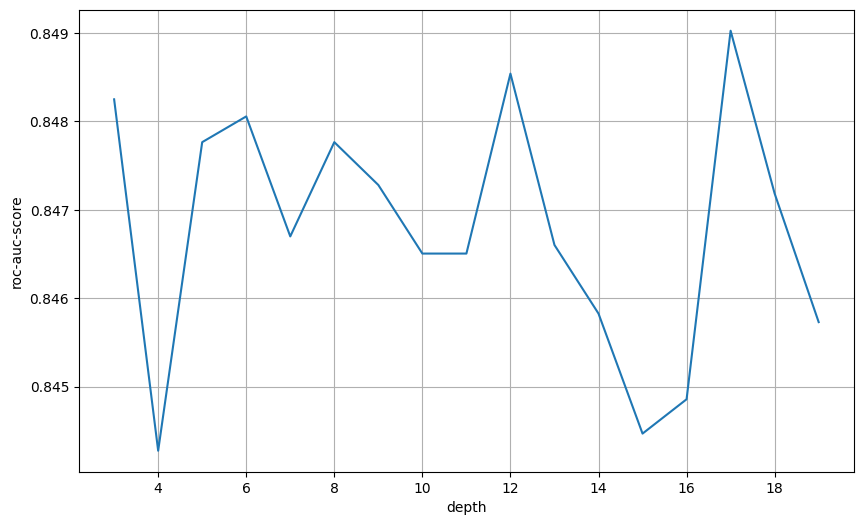

In [149]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics)
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()

### Задание
Выберите оптимальное значение глубины и обучите для этого значения единственную модель `RandomForestClassifier` на всех обучающих данных `train_data_for_forest`. Предскажите вероятность класса 1 на обучающих и тестовых данных. Сохраните их в переменные `train_y_pred_forest` и `test_y_pred_forest`. Используйте метод `predict_proba`.

In [160]:
len(rf_metrics)

17

In [177]:
d = dict(zip(depths, rf_metrics))
test_data_for_forest.columns = test_data_for_forest.columns.astype(str)

In [245]:
best_depth = max(d, key=d.get) #ВАШ КОД

model = RandomForestClassifier(n_estimators=100, max_depth=best_depth)

#ВАШ КОД. Обучите модель
model.fit(train_data_for_forest, y_train)

train_y_pred_forest = model.predict_proba(train_data_for_forest) #ВАШ КОД
test_y_pred_forest = model.predict_proba(test_data_for_forest) #ВАШ КОД

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [246]:
train_y_pred_forest = pd.DataFrame(train_y_pred_forest)[1]
test_y_pred_forest = pd.DataFrame(test_y_pred_forest)[1]

In [247]:
from sklearn.metrics import roc_curve, roc_auc_score

In [248]:
train_auc = roc_auc_score(y_train, train_y_pred_forest) #ВАШ КОД
test_auc = roc_auc_score(y_test, test_y_pred_forest) #ВАШ КОД

In [249]:
test_auc

0.9109888279355256

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [250]:
assert test_auc > 0.90

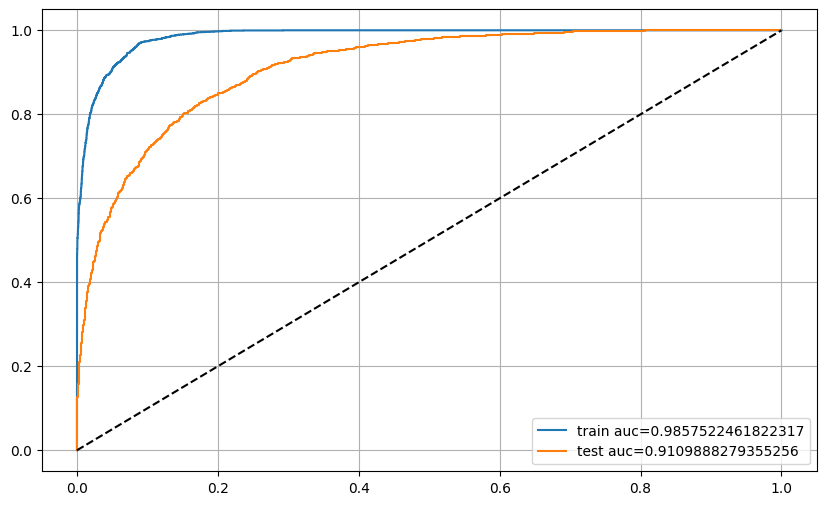

In [251]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_forest)[:2],
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_forest)[:2],
         label=f'test auc={test_auc}')


plt.plot([0,1], [0,1], '--', color='black')
plt.legend()
plt.grid()

### Задание
Создайте датасет `scoring_data_for_forest` и предскажите на нем целевую переменную.

In [259]:
scoring_data_for_forest = pd.concat([scoring_real_data, scoring_one_hot_data], axis='columns') #ВАШ КОД
scoring_data_for_forest.columns = scoring_data_for_forest.columns.astype(str)
scoring_y_pred_forest = model.predict_proba(scoring_data_for_forest)#ВАШ КОД
scoring_y_pred_forest = pd.DataFrame(scoring_y_pred_forest)[1]
scoring_y_pred_forest = list(scoring_y_pred_forest)

Сохраним scoring_y_pred_forest. Отправьте их на Stepik, полностью скопировав содержимое файла и вставив их вместо "<ВАШ КОД. Вставьте сюда list вероятностей, предсказанных случайным лесом на data_scoring.csv>" так, чтобы переменная answer содержала список вероятностей в нужном порядке.

In [260]:
with open('scoring_y_pred_forest.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_forest]))

Для посылки на kaggle обычно используют функцию `.to_csv`, как ниже, но нам этот код не понадобится:

In [ ]:
pd.Series(scoring_y_pred_forest).to_csv('scoring_y_pred_forest.csv', header=None, index=None)

## Часть 3. Обучение градиентного бустинга
Мы будем использовать библиотеку Catboost. Catboost --- это библиотека для градиентного бустинга от компании Яндекс. Она, как следует из названия, отличается удобной работой с данными вообще и категориальными признаками с частности. Про Catboost можно прочитать в [официальной документации](https://catboost.ai/en/docs/concepts/python-usages-examples) и в статье на [Хабре](https://habr.com/ru/post/599827/).

<img src="https://avatars.mds.yandex.net/i?id=53d991f7cac35c76bf747793019c39fb-3751806-images-thumbs&n=13&exp=1" style="height:400px; width:800px">

Обратите внимание на следующие моменты:
* В Catboost можно сразу передавать категориальные признаки без предварительного кодирования.
* В Catboost для категориальных признаков необходимо заполнять пропущенные значения. Мы будем заполнять их значениями `'unknown'`.
* Для работы с данными в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_pool), который называется `Pool`. Прочитать о нем можно также в [примерах использования](https://catboost.ai/en/docs/concepts/python-usages-examples).
* Для кросс-валидации в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_cv) `cv`. Об использовании можно прочитать в статье на [Хабре](https://habr.com/ru/post/599827/).
* Собственно, основная модель для классификации в Catboost --- это `CatBoostClassifier`.

Для установки `catboost` вы можете выполнить следующую команду.

In [261]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


Импортируем все необходимые классы.

In [262]:
from catboost import CatBoostClassifier, Pool, cv

### Задание
Заполните пропуски в данных `train_cat_data` и `test_cat_data` значением `'unknown'`. Используйте метод `fillna`.

In [263]:
train_cat_data = train_cat_data.fillna('unknown') #ВАШ КОД
test_cat_data = test_cat_data.fillna('unknown') #ВАШ КОД

### Задание
Создайте новые наборы данных для train и test, состоящие из `[train/test]_real_data` и `[train/test]_cat_data`. Используйте `pd.concat`. Затем создайте обучающий и тестовый `Pool` (за вас мы выделили номера категориальных признаков).

In [264]:
train_data_for_boosting = pd.concat([train_real_data, train_cat_data], axis='columns') #ВАШ КОД. Используйте pd.concat
test_data_for_boosting = pd.concat([test_real_data, test_cat_data], axis='columns') #ВАШ КОД. Используйте pd.concat

cat_features = np.arange(train_cat_data.shape[1]) + train_real_data.shape[1]

train_dataset = Pool(data=train_data_for_boosting,
                     label=y_train,
                     cat_features=cat_features)

test_dataset = Pool(data=test_data_for_boosting,
                     label=y_test,
                     cat_features=cat_features) # ВАШ КОД. Сделайте то же самое для test

Для каждого значения depth от 3 до 16 включительно используйте функцию `cv` для подсчета результатов кросс-валидации. Затем посчитайте среднее по фолдам значение метрики ROC-AUC с последней итерации и запишите получившиеся данные в массив `boosting_metrics`.

Обратите внимание, что функция `cv` должна принимать следующие параметры:
* `pool` (используйте `train_dataset`)
* `params` (используйте параметры, указанные в коде)
* `fold_count` (положите равным 5).

Функция cv возвращает pd.DataFrame с метриками обучения. Вам понадобится колонка `'test-AUC-mean'` и последняя строчка. Обратите внимание, что обучение занимает значительное время! Сначала можете попробовать выполнить этот код для небольшого массива `depths`, чтобы было легче дебагать.

In [319]:
depths = np.arange(3, 17)
boosting_metrics = []

for depth in depths:
    params = {"iterations": 100,
              "depth": depth,
              "loss_function": "Logloss",
              "custom_loss": "AUC",
              "verbose": False}

    scores = cv(pool=train_dataset, params=params, fold_count=5) #ВАШ КОД. Используйте функцию cv
    boosting_metrics.append(scores['test-AUC-mean'][99])

Training on fold [0/5]

bestTest = 0.3273096307
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3256410029
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3362996427
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3246846564
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3287240336
bestIteration = 99

Training on fold [0/5]

bestTest = 0.3208455717
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3192997499
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3303181483
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3157807229
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3212674113
bestIteration = 99

Training on fold [0/5]

bestTest = 0.3154006551
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3158262487
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3268619454
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3124302491
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3179742042


In [328]:
d2 = dict(zip(depths, boosting_metrics))

Построим график получившейся метрики в зависимости от параметра `depth`. Сравним его с тем же графиком для метрик случайного леса.

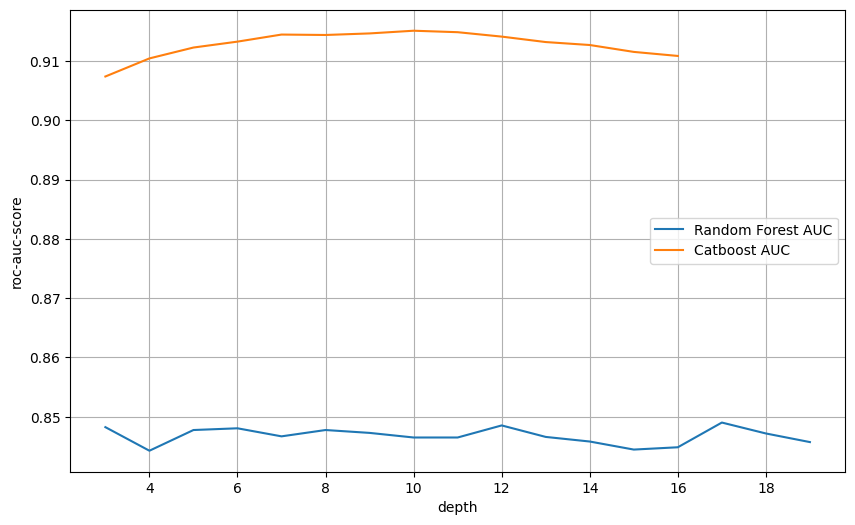

In [329]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics, label='Random Forest AUC')
plt.plot(np.arange(3, 17), boosting_metrics, label='Catboost AUC')
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()
plt.legend()

Ответье на следующие вопросы:
* Для какой модели общие результаты получились лучше? Если лучше результаты получились у бэггинга, как вы думаете, получится ли у бустинга отыграться на полной выборке и при большем количестве деревьев?
* Какова получилась оптимальная глубина для бустинга?
* Как она отличается от оптимальной глубины для бэггинга?

### Задание
Мы нашли оптмальную глубину. Обучите для этого значения глубины один `CatBoostClassifier` со следующими параметрами:
* `iterations=500` (именно 500, потому что качества с сотней деревьев может не хватить!)
* `depth =` глубина, которую вы нашли
* `loss_function='Logloss'`
* `verbose=False` (чтобы не было лишнего вывода).

Обучение производится с помощью метода `fit`, который принимает единственный аргумент --- `Pool` с данными. В данном случае используйте `train_dataset`.

Предскажите значения на `train_dataset` и `test_dataset`. Это делается методом `predict_proba` (устроен так же, как и в `sklearn`).

In [350]:
best_depth = max(d2, key=d2.get)

model = CatBoostClassifier( verbose=False) #ВАШ КОД. Создайте объект класса CatBoostClassifier

model.fit(train_dataset) #ВАШ КОД. Обучите модель на train_dataset


train_y_pred_boosting = model.predict_proba(train_dataset) #ВАШ КОД. Используйте predict_proba
test_y_pred_boosting = model.predict_proba(test_dataset) #ВАШ КОД. Используйте predict_proba

In [351]:
train_y_pred_boosting = pd.DataFrame(train_y_pred_boosting)[1]
test_y_pred_boosting = pd.DataFrame(test_y_pred_boosting)[1]

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [352]:
train_auc = roc_auc_score(y_train, train_y_pred_boosting) #ВАШ КОД
test_auc = roc_auc_score(y_test, test_y_pred_boosting) #ВАШ КОД

In [353]:
test_auc

0.9257894840860901

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [354]:
assert test_auc > 0.915

Построим ROC-кривые для получившейся модели.

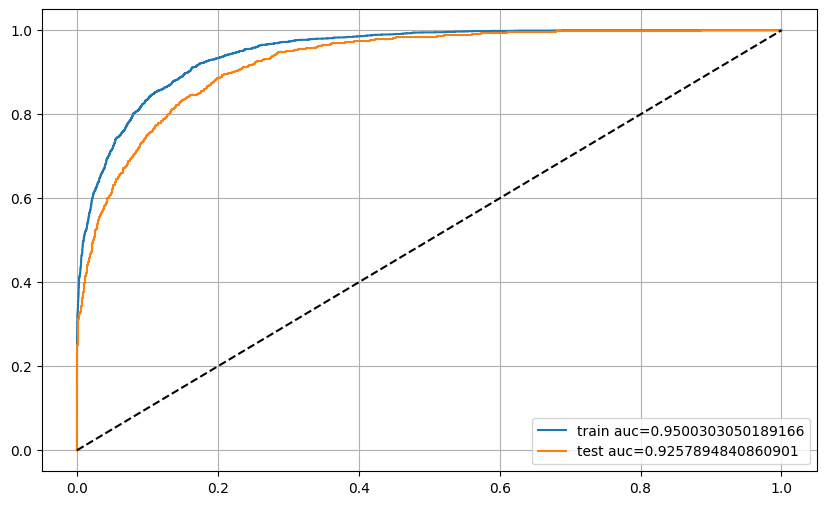

In [355]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_boosting)[:2],
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_boosting)[:2],
         label=f'test auc={test_auc}')

plt.plot([0,1], [0,1], '--', color='black')

plt.legend()
plt.grid()

### Задание
Примените построенную модель к данным `scoring_data`. Для этого повторите все шаги, которые вы делали с тестовыми данными:
* Заполнение пропущенных значений
* Конкатенация числовых и категориальных данных
* Создание `scoring_dataset` (здесь не нужно передавать аргумент `label`, так как мы их не знаем)
* Предсказание вероятностей 1 класса

In [356]:
#ВАШ КОД
scoring_cat_data = scoring_cat_data.fillna('unknown')
scoring_d = pd.concat([scoring_real_data, scoring_cat_data], axis='columns')
scoring_dataset = Pool(data=scoring_d,
                     cat_features=cat_features)

predictions = model.predict_proba(scoring_dataset) #ВАШ КОД. Сохраните вероятности, предсказанные моделью

In [357]:
scoring_d

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex
0,17,256173,6,0,0,15,unknown,10th,Never-married,unknown,Own-child,White,Female
1,31,265706,13,0,0,40,Private,Bachelors,Never-married,Sales,Not-in-family,White,Male
2,61,244087,9,0,0,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male
3,60,232618,9,0,0,40,Local-gov,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male
4,56,34626,10,0,1980,40,Private,Some-college,Divorced,Exec-managerial,Not-in-family,White,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,25,514716,13,0,0,40,Local-gov,Bachelors,Never-married,Adm-clerical,Own-child,Black,Female
1542,32,207668,13,15024,0,45,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male
1543,27,104457,13,0,0,40,Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male
1544,59,268700,9,0,0,40,State-gov,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male


In [358]:
scoring_y_pred_boosting = pd.DataFrame(predictions)[1]
scoring_y_pred_boosting

0       0.000068
1       0.091380
2       0.306320
3       0.136417
4       0.071598
          ...   
1541    0.008632
1542    0.996655
1543    0.015357
1544    0.136072
1545    0.926065
Name: 1, Length: 1546, dtype: float64

Сохраним предсказанные значения. Отправьте их на Stepik.

In [359]:
with open('scoring_y_pred_boosting.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_boosting]))